In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import erf
from scipy.optimize import minimize
import jax
from jax import grad
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from utils import *


### Integrating f(t)

So we have:
$$
\boxed{v[k] = \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \, \left[\frac{1}{2} \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2} \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right]}
$$     

$$
\boxed{vv[k] = \sigma_f^2 \left[ \sigma \sqrt{2\pi} \, (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + 2 \sigma^2 \left( e^{-{\frac{(x-a)^2}{2 \sigma^2}}} - 1 \right) \right]}
$$


$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$


where $$\textbf{k}_F(x) = \Big[ \int_a^x k(t, x_1)dt,\, \int_a^x k(t, x_2)dt,\, \cdots ,\, \int_a^x k(t, x_n)dt \Big]$$,
$$K(x'x) = \int_a^x \int_a^{x'} k(t, s)\,ds\,dt $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

In [2]:
def vk(input,lower, upper, s=1,L=1):
    t1 = jnp.sqrt(2*jnp.pi)
    t2 = (0.5*erf((upper-input)/(L*jnp.sqrt(2))) - 0.5*erf((lower-input)/(L*jnp.sqrt(2))))
    return s**2*L*t1*t2

def vvk(lower, upper, s=1, L=1):
    t1 = L*jnp.sqrt(2*jnp.pi)*(upper-lower)
    t2 = erf((upper-lower)/(L*jnp.sqrt(2)))
    t3 = jnp.exp(-(upper-lower)**2/(2*L**2)) - 1
    return s**2*(t1*t2 + 2*L**2*t3)

def integrate_rbf(x_eval,y_eval, lower, upper, s=1,L=1):
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    kxx = rbf(x_eval,x_eval.T,s,L)
    kxx += 1e-10*jnp.eye(len(kxx))
    kxx = (kxx + kxx.T)/2
    
    kf = vk(x_eval,lower,upper,s,L)

    mu = kf.reshape(1,-1)@jnp.linalg.solve(kxx,y_eval)
    var = vvk(lower,upper,s,L) - kf.reshape(1,-1)@jnp.linalg.solve(kxx,kf.reshape(-1,1))
    var = jnp.maximum(var, 0.0)
    
    return mu, var

Bayesian Quadrature
2 pts:
True value: 5.96051236421104

Optimised params: [  1.91789645 385.93580046]
Optimised log marginal likelihood: 0.4265395268526855

Estimate: 7.67145858 , StDev: 0.00010096
Absolute Error: 1.71094622



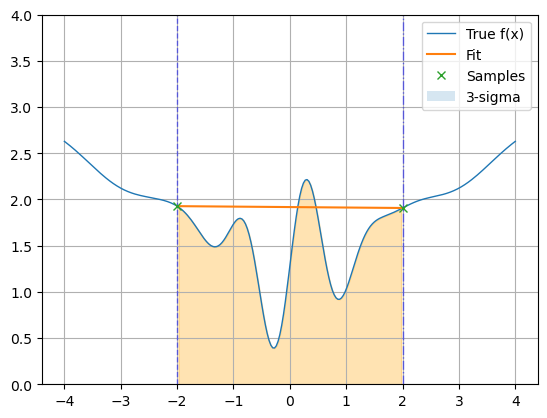

4 pts:
True value: 5.96051236421104

Optimised params: [1.81417745 2.38300373]
Optimised log marginal likelihood: -5.074665594038607

Estimate: 6.02543584 , StDev: 0.03377647
Absolute Error: 0.06492348



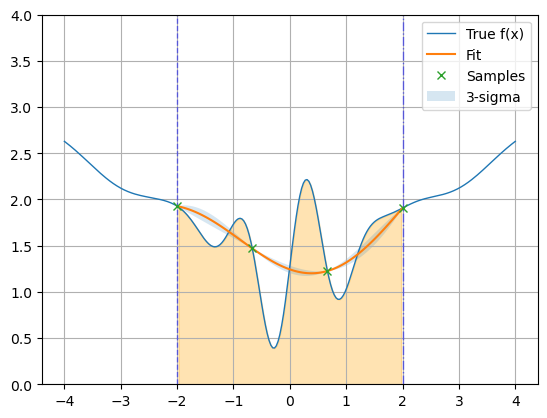

6 pts:
True value: 5.96051236421104

Optimised params: [1.52976285 0.67819713]
Optimised log marginal likelihood: -10.19411677575175

Estimate: 6.03020206 , StDev: 0.13373327
Absolute Error: 0.06968970



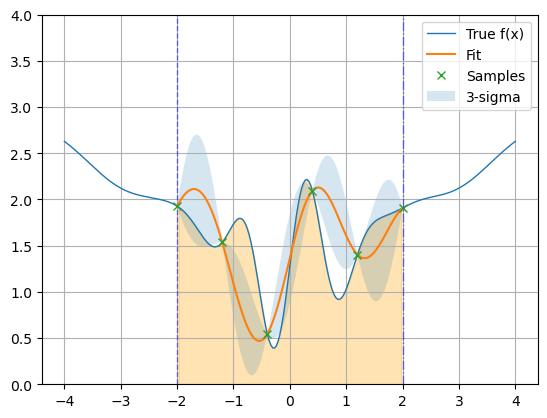

10 pts:
True value: 5.96051236421104

Optimised params: [1.43252596 0.40704599]
Optimised log marginal likelihood: -15.635834180971509

Estimate: 6.00055340 , StDev: 0.05516098
Absolute Error: 0.04004103



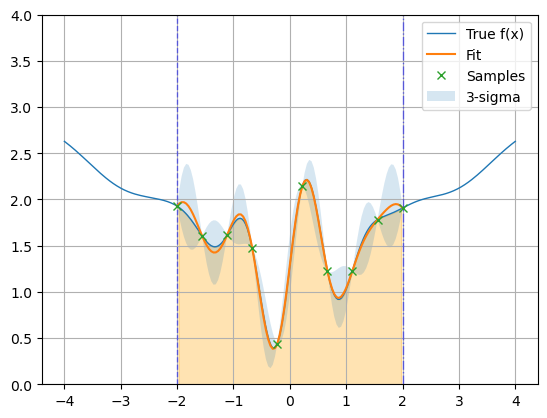

15 pts:
True value: 5.96051236421104

Optimised params: [1.53869974 0.47551346]
Optimised log marginal likelihood: -8.871250834321124

Estimate: 5.96353715 , StDev: 0.00300421
Absolute Error: 0.00302478



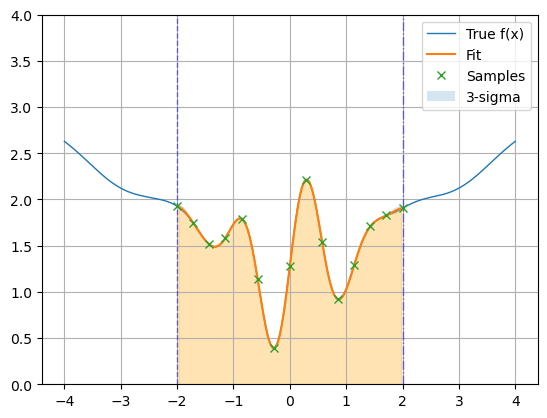

In [3]:
def f(x):
    return jnp.exp(-x**2)*jnp.sin(5*x) + jnp.log(1 + x**2)/(1 + x**4) + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)

lower = -2
upper = 2
interval = upper - lower

points = np.linspace(lower-0.5*interval,upper+0.5*interval,250)
yy = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = yy[mask]


true_value = 5.96051236421104

x_eval = np.linspace(lower,upper,100)
print("Bayesian Quadrature")
for n in [2,4,6,10,15]:
    x = jnp.linspace(lower,upper,n)
    y = f(x)


    grad_fn = grad(neg_gp_likelihood)
    s_init = 1
    #diagonal L
    l_init = jnp.array([1])
    init_params = jnp.concatenate([jnp.array([s_init]), l_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
        method="L-BFGS-B",
        bounds=[(1e-3, None)] * len(init_params)
    )


    plt.plot(points,yy, label='True f(x)', linewidth=1)
    plt.axvline(lower, color='b', linestyle='--',linewidth=1, alpha=0.5)
    plt.axvline(upper, color='b', linestyle='-.',linewidth=1, alpha=0.5)
    plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
    plt.grid()

    #kernel hyperparameters
    s = res.x[0]
    L = jnp.diag(res.x[1:])


    #points to plot gp
    mu_eval,var_eval = gp_predict(x,y,x_eval,kernel=rbf,s=s,L=L)
    # sig_diag = np.sqrt(np.clip(np.diag(var_eval), 0.0, None))
    sig_diag = jnp.sqrt(jnp.diag(var_eval))

    I_mu, I_var = integrate_rbf(x,y,lower,upper,s,L)
    error = np.abs(true_value - I_mu[0][0])
    print(f"{n} pts:")
    print(f"True value: {true_value}")
    print()
    print("Optimised params:", res.x)
    print("Optimised log marginal likelihood:", -res.fun)
    print()
    print(f"Estimate: {I_mu[0][0]:.8f} , StDev: {np.sqrt(I_var[0][0]):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

    
    #plot gp
    plt.plot(x_eval,mu_eval,label='Fit')
    plt.plot(x,y,'x',label='Samples')
    plt.ylim(0,4)
    plt.fill_between(x_eval,mu_eval-2*sig_diag,mu_eval+2*sig_diag,alpha=0.18,label='3-sigma')
    plt.legend()
    plt.show()


### Integrating f(t)p(t) - univariate case

So we have:

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \; \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right]}
$$

$$
\boxed{vv[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + 2 \sigma_p^2}}}
$$



where $$\textbf{k}_F(x) = \Big[ \int k(t, x_1)p(t)dt,\, \int k(t, x_2)p(t)dt,\, \cdots ,\, \int k(t, x_n)p(t)dt \Big]$$,
$$K(x'x) = \int \int k(t, s)p(t)p(s)\,ds\,dt $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

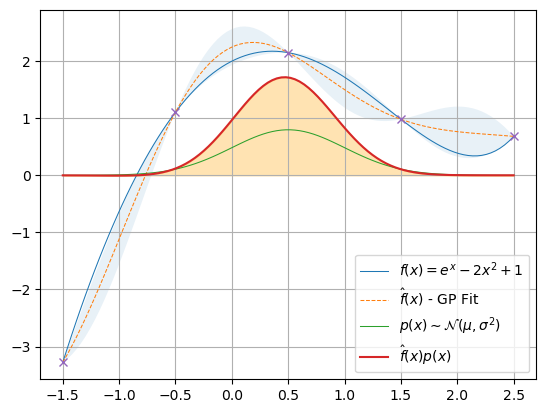

Eₚ[f(x)]: 1.8682459574322223

Bayesian Quadrature
1 pts:
Optimised params: [1.10653015 0.5       ]
Optimised log marginal likelihood: -1.5201681220623735
Estimate: 0.28784187 , StDev: 0.78997467
Absolute Error: 1.58040408

4 pts:
Optimised params: [1.32566629 1.12996312]
Optimised log marginal likelihood: -4.059963713457724
Estimate: 1.87116879 , StDev: 0.00157505
Absolute Error: 0.00292284

8 pts:
Optimised params: [2.8244946  1.40270729]
Optimised log marginal likelihood: 10.054355556565309
Estimate: 1.86820136 , StDev: 0.00006591
Absolute Error: 0.00004460

16 pts:
Optimised params: [3.52479664 1.52500503]
Optimised log marginal likelihood: 55.78181437235306
Estimate: 1.86820909 , StDev: 0.00002788
Absolute Error: 0.00003686

32 pts:
Optimised params: [3.8816996  1.58285823]
Optimised log marginal likelihood: 149.62179042764234
Estimate: 1.86821287 , StDev: 0.00002131
Absolute Error: 0.00003309



In [4]:
def f(x):
    return jnp.exp(x) - 2*x**2 + 1

def fp(x, mu, sigma):
    px = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x-mu)**2/(2*sigma**2))
    return f(x)*px

def FP(mu, sigma):
    t1 = jnp.exp(sigma**2/2 + mu)
    return t1 - 2*sigma**2 - 2*mu**2 + 1

#integral of f(x) from lower to upper
mu = 0.5
sigma = 0.5
true_value = FP(mu,sigma)


#sample n points
n = 5
x = jnp.linspace(mu-4*sigma,mu+4*sigma,n)
y = f(x)

grad_fn = grad(neg_gp_likelihood)
s_init = 1
#diagonal L
l_init = jnp.array([1])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
    method="L-BFGS-B",
    bounds=[(1e-3, None)] * len(init_params)
)

#kernel hyperparameters
s = res.x[0]
L = jnp.diag(res.x[1:])

#points to plot gp
x_eval = np.linspace(mu-4*sigma,mu+4*sigma,100)
mu_eval,var_eval = gp_predict(x,y,x_eval,kernel=rbf,s=s,L=L)
sig_diag = np.sqrt(np.clip(np.diag(var_eval), 0.0, None))

#real curve
y1 = f(x_eval)
y2 = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x_eval-mu)**2/(2*sigma**2))
y3 = fp(x_eval,mu,sigma)


mask = (x_eval >= mu-4*sigma) & (x_eval <= mu+4*sigma)
points_fill = x_eval[mask]
y_fill = y3[mask]

#plot gp
plt.plot(x_eval,y1,label=r'$f(x) = e^x - 2x^2 + 1$', ls='-',lw=0.75)
plt.plot(x_eval, mu_eval, label=r'$\hat{f}(x)$ - GP Fit', ls='--', lw=0.75)
plt.plot(x_eval, y2, label=r'$p(x) \sim \mathcal{N}(\mu, \sigma^2)$', ls='-', lw=0.75)
plt.plot(x_eval,y3,label=r'$\hat{f}(x)p(x)$', ls='-')
plt.plot(x,y,'x')
plt.fill_between(x_eval,mu_eval-2*sig_diag,mu_eval+2*sig_diag,alpha=0.1)
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
plt.legend()
plt.grid()
plt.show()


print(f"Eₚ[f(x)]: {true_value}")
print()
print("Bayesian Quadrature")
for n in [1,4,8,16,32]:

    x = np.linspace(mu-2*sigma,mu+2*sigma,n)
    y = f(x)

    grad_fn = grad(neg_gp_likelihood)
    s_init = 0.5
    #diagonal L
    l_init = jnp.array([0.5])
    init_params = jnp.concatenate([jnp.array([s_init]), l_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
        method="L-BFGS-B",
        bounds = [(1e-3, None)] * len(init_params)

    )


    #kernel hyperparameters
    s = res.x[0]
    L = jnp.diag(res.x[1:])


    I_mu, I_var = integrate_gaussian_1(x,y,s,L,mu,sigma)

    error = np.abs(true_value - I_mu)
    print(f"{n} pts:")
    print("Optimised params:", res.x)
    print("Optimised log marginal likelihood:", -res.fun)
    print(f"Estimate: {I_mu:.8f} , StDev: {np.sqrt(I_var):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

## Bayesian Quadrature
### Integrating f(t)p(t) - multivariate case

So we have:

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 |\mathbf{L}| |\Sigma_p + \mathbf{L^2}|^{-1/2} \exp\Big[-\frac{1}{2} (\mathbf{s}-\boldsymbol{\mu}_p)^T (\Sigma_p +  \mathbf{L^2})^{-1} (\mathbf{s}-\boldsymbol{\mu}_p) \Big]}
$$

$$
\boxed{vv[k] = \sigma_f^2 |\mathbf{L}| \, |2\Sigma_p + \mathbf{L^2}|^{-1/2}}
$$

where $$\textbf{k}_F(x) = \Big[ \int k(\boldsymbol{t}, x_1)p(\boldsymbol{t})d\boldsymbol{t},\, \int k(\boldsymbol{t}, x_2)p(\boldsymbol{t})d\boldsymbol{t},\, \cdots ,\, \int k(\boldsymbol{t}, x_n)p(\boldsymbol{t})d\boldsymbol{t} \Big]$$,
$$K(x'x) = \int \int k(\boldsymbol{t}, \boldsymbol{s})p(\boldsymbol{t})p(\boldsymbol{s})\,d\boldsymbol{s}\,d\boldsymbol{t} $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

E[x^2 + y^2]
Bivariate normal with mean: [3, -2] and cov: [[2, -1], [-1, 2]]

MC estimate: 16.986239198587633
MC stdev: 0.00926680667985203
GP estimate: 16.996553402798256
GP stdev: 0.00039969742406521574


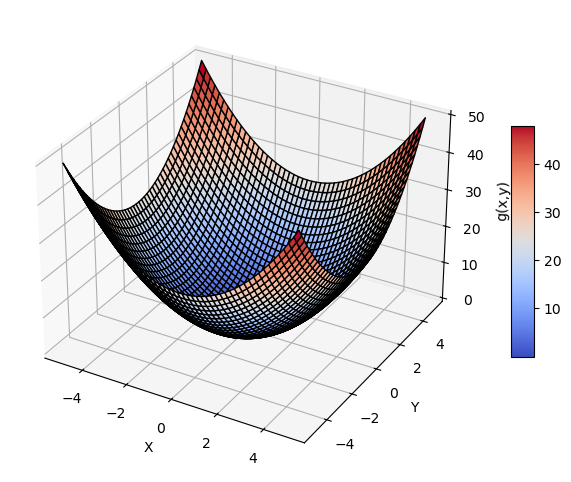

In [9]:
def mc_nd(func, mean, cov, n=100_000):
    samples = np.random.multivariate_normal(mean, cov, size=n)
    values = func(*samples.T)
    
    mean_est = np.mean(values)
    se_est = np.std(values, ddof=1) / np.sqrt(n)
    
    return mean_est, se_est


# Example function g(x,y)
def g(x, y):
    return x**2 + y**2

mean = [3, -2]
cov = [[2, -1],
       [-1, 2]]

ev = mc_nd(g, mean, cov, n=2000000)
print('E[x^2 + y^2]')
print(f"Bivariate normal with mean: {mean} and cov: {cov}")
print()

print("MC estimate:", ev[0])
print("MC stdev:", ev[1])


#training data
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
x, Y = np.meshgrid(x, y)
xy = jnp.column_stack([x.ravel(), Y.ravel()])
gxy1 = g(xy[:, 0], xy[:, 1]).reshape(-1,1)

mu_p = jnp.array(mean)
S_p = jnp.array(cov)

#kernel hyperparameters
s = 20
L = [5,5]

#compute integral
mu_int, var_int = integrate_gaussian_n(xy, gxy1, s, L, mean, cov)
print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))


#evaluation points
x_eval = np.linspace(-5, 5, 50)
y_eval = np.linspace(-5, 5, 50)
X_eval, Y_eval = np.meshgrid(x_eval, y_eval)
xy_eval = np.column_stack([X_eval.ravel(), Y_eval.ravel()])
mu_grid, var_grid = gp_predict(xy, gxy1, xy_eval, kernel=rbf, s=s, L=L)
mu_grid = mu_grid.reshape(X_eval.shape)

#plot GP surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_eval, Y_eval, mu_grid, cmap=cm.coolwarm, edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('g(x,y)')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


In [ ]:
def g3(x, y, z):
    return x**2 + y**2 + z**2

mean = [3, -2, 1]
cov = [[2, -1, 1], [-1, 3, 1], [1, 1, 2]]

ev = mc_nd(g3, mean, cov, n=2000000)
print('E[x^2 + y^2 + z^2]')
print(f"Normal with mean: {mean} and cov: {cov}")
print()

print("MC estimate:", ev[0])
print("MC stdev:", ev[1])


# Example: 3D data
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
z = np.linspace(-5, 5, 10)
x, Y, Z = np.meshgrid(x, y, z)
xyz = np.column_stack([x.ravel(), Y.ravel(), Z.ravel()])
gxyz = g3(*xyz.T).reshape(-1, 1)

L = [5,5,5]

mu_int, var_int = integrate_gaussian_n(xyz, gxyz, s, L, mean, cov)
print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))

E[x^2 + y^2 + z^2]
Normal with mean: [3, -2, 1] and cov: [[2, -1, 1], [-1, 3, 1], [1, 1, 2]]

MC estimate: 20.98488653708435
MC stdev: 0.01071135661618702
GP estimate: 20.994274706624452
GP stdev: 0.00047644545440662505
